In [17]:
import torch

num_gpus = torch.cuda.device_count()
num_cpus = torch.get_num_threads()

print(f"Number of available CPU cores: {num_cpus}")
print(f"Number of available GPUs: {num_gpus}")

Number of available CPU cores: 1
Number of available GPUs: 1


In [18]:
!git clone https://github.com/aliabbasi2000/PIDNet.git
%cd /content/PIDNet/

Cloning into 'PIDNet'...
remote: Enumerating objects: 595, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 595 (delta 17), reused 17 (delta 8), pack-reused 558 (from 1)
Receiving objects: 100% (595/595), 246.53 MiB | 32.88 MiB/s, done.
Resolving deltas: 100% (245/245), done.
/content/PIDNet


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# Define path to your Google Drive files
train_zip_path = '/content/drive/MyDrive/Train.zip'

# Unzip the files directly from Google Drive into the current directory
!unzip "{train_zip_path}" -d ./LoveDA

print("Data unzipped successfully!")

Streaming output truncated to the last 5000 lines.
 extracting: ./LoveDA/Train/Rural/images_png/1039.png  
 extracting: ./LoveDA/Train/Rural/images_png/104.png  
  inflating: ./LoveDA/Train/Rural/images_png/1040.png  
 extracting: ./LoveDA/Train/Rural/images_png/1041.png  
 extracting: ./LoveDA/Train/Rural/images_png/1042.png  
 extracting: ./LoveDA/Train/Rural/images_png/1043.png  
  inflating: ./LoveDA/Train/Rural/images_png/1044.png  
 extracting: ./LoveDA/Train/Rural/images_png/1045.png  
 extracting: ./LoveDA/Train/Rural/images_png/1046.png  
 extracting: ./LoveDA/Train/Rural/images_png/1047.png  
 extracting: ./LoveDA/Train/Rural/images_png/1048.png  
 extracting: ./LoveDA/Train/Rural/images_png/1049.png  
  inflating: ./LoveDA/Train/Rural/images_png/105.png  
  inflating: ./LoveDA/Train/Rural/images_png/1050.png  
  inflating: ./LoveDA/Train/Rural/images_png/1051.png  
 extracting: ./LoveDA/Train/Rural/images_png/1052.png  
 extracting: ./LoveDA/Train/Rural/images_png/1053.png  

In [21]:
!wget --content-disposition "https://drive.usercontent.google.com/u/0/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-&export=download"
!mv PIDNet_S_ImageNet.pth.tar /content/PIDNet/pretrained_models/imagenet

--2025-01-18 18:31:20--  https://drive.usercontent.google.com/u/0/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.153.132, 2a00:1450:4013:c16::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.153.132|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.usercontent.google.com/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-&export=download [following]
--2025-01-18 18:31:20--  https://drive.usercontent.google.com/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-&export=download
Reusing existing connection to drive.usercontent.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-&export=download [following]
--2025-01-18 18:31:20--  https://drive.usercontent.google.com/download?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-&export=download
Reusing e

In [22]:
import os
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from albumentations import Compose, Normalize, Resize
from albumentations.pytorch import ToTensorV2
import cv2

class LoveDADataset(Dataset):
    def __init__(self, root, split='train', region='urban', transform=None):
        self.root = root
        self.split = split
        self.region = region
        self.image_dir = os.path.join(root, split, region, 'images_png')
        self.mask_dir = os.path.join(root, split, region, 'masks_png')
        self.images = sorted(os.listdir(self.image_dir))
        self.masks = sorted(os.listdir(self.mask_dir))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
      image_path = os.path.join(self.image_dir, self.images[idx])
      mask_path = os.path.join(self.mask_dir, self.masks[idx])

      # Load the image and mask
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
      mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

      # Convert mask to tensor and shift labels
      mask = np.array(mask, dtype=np.int64) - 1  # Shift labels to range [0, 6]
      mask = np.clip(mask, 0, num_classes - 1)  # Ensure no negative values

      # Apply transformations if specified
      if self.transform:
          augmented = self.transform(image=image, mask=mask)
          image = augmented["image"]
          mask = augmented["mask"]

      # Convert to PyTorch tensors
      image = image.clone().detach().float()  # HWC to CHW
      mask = mask.clone().detach().long()

      return image, mask


In [23]:
from torch.utils.data import DataLoader
from albumentations import Compose, HorizontalFlip, RandomRotate90, RandomCrop, VerticalFlip, Normalize, OneOf, NoOp, GaussianBlur, RandomBrightnessContrast, MultiplicativeNoise
from torchvision.transforms import ToTensor
from torchvision import transforms

# Define transforms for training phase
from albumentations.pytorch import ToTensorV2

train_transform = Compose([
    Resize(512, 512),  # Resize both image and mask
    # Augmentation
    OneOf([
      HorizontalFlip(p=0.5),
      VerticalFlip(p=0.5),
      RandomRotate90(p=0.5),
      GaussianBlur(blur_limit=(3, 7), p=0.5),
      RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),  # Adjust brightness and contrast
      MultiplicativeNoise(multiplier=(0.9, 1.1), p=0.5),

      NoOp()  # do no augmentation some times
    ], p=0.75),  # The entire block is applied with 75% probability

    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], always_apply=True),  # Normalize
    ToTensorV2()  # Convert to PyTorch tensors
])

# Define transforms for the evaluation phase

eval_transform = Compose([
    Resize(512, 512),  # Resize to match the input size of the model
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], always_apply=True),  # Normalize with ImageNet stats
    ToTensorV2()  # Convert to PyTorch tensors
])

# Define dataset paths
data_root = '/content/PIDNet/LoveDA'


# Load datasets
source_dataset = LoveDADataset(root=data_root, split='Train', region='Urban', transform=train_transform)
target_dataset = LoveDADataset(root=data_root, split='Train', region='Rural', transform=eval_transform)


# Create DataLoaders
source_loader = DataLoader(source_dataset, batch_size=8, shuffle=True, num_workers=2)
target_loader = DataLoader(target_dataset, batch_size=8, shuffle=False, num_workers=2)



In [24]:
import torch
from models.pidnet import get_seg_model
import yaml

## get_pred ------------------------------------
#model = get_pred_model('pidnet_s', num_classes=7)

## get_seg ------------------------------------
# Convert the dictionary to a DotDict
class DotDict(dict):
    """A dictionary that supports attribute-style access."""
    def __getattr__(self, name):
        value = self.get(name)
        if isinstance(value, dict):
            return DotDict(value)
        return value

    def __setattr__(self, name, value):
        self[name] = value

# Load the YAML configuration
with open('/content/PIDNet/configs/loveda/pidnet_small_loveda.yaml', 'r') as f:
    cfg_dict = yaml.safe_load(f)

# Convert to DotDict for attribute-style access
cfg = DotDict(cfg_dict)

imgnet = 'imagenet' in cfg.MODEL.PRETRAINED

model = get_seg_model(cfg, imgnet_pretrained=imgnet)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)




In [27]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss()

'''optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)'''
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [28]:
import torch.nn.functional as F

def calculate_iou(predictions, ground_truth, num_classes):
    classwise_iou = []
    for cls in range(num_classes):
        tp = ((predictions == cls) & (ground_truth == cls)).sum().item()
        fp = ((predictions == cls) & (ground_truth != cls)).sum().item()
        fn = ((predictions != cls) & (ground_truth == cls)).sum().item()

        if tp + fp + fn == 0:
            iou = float('nan')
        else:
            iou = tp / (tp + fp + fn)
        classwise_iou.append(iou)

    return classwise_iou

# Training
model.train()
num_epochs = 20
num_classes = 7
class_labels = ["background", "building", "road", "water", "barren", "forest", "agriculture"]

for epoch in range(num_epochs):
    train_loss = 0.0

    for images, masks in source_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)

        # Assuming 'outputs' is a list and the desired output is the first element:
        outputs = outputs[0]  # Select the first element of the list

        # Resize masks to match outputs in size= ...
        masks = F.interpolate(masks.unsqueeze(1).float(), size=(outputs.shape[2], outputs.shape[3]), mode='nearest').squeeze(1).long()
        loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(source_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}")
    scheduler.step()
    torch.save(model.state_dict(), 'trained_on_urban_eval_on_rural.pth')


Epoch 1/20, Training Loss: 0.8187
Epoch 2/20, Training Loss: 0.8169
Epoch 3/20, Training Loss: 0.8180
Epoch 4/20, Training Loss: 0.7997
Epoch 5/20, Training Loss: 0.7994
Epoch 6/20, Training Loss: 0.8039
Epoch 7/20, Training Loss: 0.8066
Epoch 8/20, Training Loss: 0.8022
Epoch 9/20, Training Loss: 0.7992
Epoch 10/20, Training Loss: 0.7963
Epoch 11/20, Training Loss: 0.7991
Epoch 12/20, Training Loss: 0.7957
Epoch 13/20, Training Loss: 0.7951
Epoch 14/20, Training Loss: 0.8023
Epoch 15/20, Training Loss: 0.7955
Epoch 16/20, Training Loss: 0.7948
Epoch 17/20, Training Loss: 0.7948
Epoch 18/20, Training Loss: 0.7948
Epoch 19/20, Training Loss: 0.8002
Epoch 20/20, Training Loss: 0.7918


In [29]:
import torch
import torch.nn.functional as F

# Switch the model to evaluation mode
model.eval()

# Initialize a list to store pseudo-labels
pseudo_labels = []

# Confidence threshold for filtering predictions
confidence_threshold = 0.9

# Iterate through the target dataset
with torch.no_grad():
    for images, _ in target_loader:  # (target dataset)
        images = images.to(device)

        # Forward pass to get outputs
        outputs = model(images)

        # Convert logits to probabilities
        probabilities = F.softmax(outputs[0], dim=1)

        # Get predictions and confidence scores
        predictions = probabilities.argmax(dim=1)
        confidence = probabilities.max(dim=1).values

        # Filter predictions by confidence threshold
        confident_predictions = predictions.clone()
        confident_predictions[confidence < confidence_threshold] = -1

        # Append confident predictions to the list
        pseudo_labels.extend(confident_predictions.cpu().tolist()) # Extend the list with individual predictions

# Save pseudo-labels to disk
torch.save(pseudo_labels, 'pseudo_labels.pth')

print("Pseudo-labels generated and saved as 'pseudo_labels.pth'.")

Pseudo-labels generated and saved as 'pseudo_labels.pth'.


In [30]:
def generate_full_classmix_mask(source_label):
    """
    Generate a binary mask that covers all classes for full mixing.
    :param source_label: Source label (tensor of shape HxW)
    :return: Binary mask (tensor of shape HxW) with random mixing across all classes
    """
    # Generate a random binary mask for full-class mixing
    mask = torch.rand_like(source_label, dtype=torch.float32) > 0.5
    return mask


In [31]:
def mix_images_and_labels(source_image, source_label, target_image, target_label, mask):
    """
    Mix source and target images and labels based on the binary mask.
    :param source_image: Source image (CxHxW)
    :param source_label: Source label (HxW)
    :param target_image: Target image (CxHxW)
    :param target_label: Target label (HxW)
    :param mask: Binary mask (HxW)
    :return: Mixed image and mixed label
    """
    mixed_image = source_image.clone()
    mixed_label = source_label.clone()

    # Apply mask to mix source and target
    mixed_image[:, mask] = target_image[:, mask]
    mixed_label[mask] = target_label[mask]

    return mixed_image, mixed_label


In [32]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

class MixedLoveDADataset(Dataset):
    def __init__(self, source_dataset, target_dataset, pseudo_labels, num_classes, transform=None):
        """
        Initializes the MixedLoveDADataset, combining source dataset with labeled data
        and target dataset with pseudo-labels.

        Args:
            source_dataset (Dataset): Source domain dataset with ground truth labels.
            target_dataset (Dataset): Target domain dataset without ground truth labels.
            pseudo_labels (list): Pseudo-labels for the target domain dataset.
            num_classes (int): Number of classes in the dataset.
            transform (callable, optional): Transformations to apply to the images.
        """
        self.source_dataset = source_dataset
        self.target_dataset = target_dataset
        self.pseudo_labels = pseudo_labels  # Pseudo-labels as a list
        self.num_classes = num_classes
        self.transform = transform

    def __len__(self):
        """Returns the total length of the combined dataset."""
        return len(self.source_dataset) + len(self.target_dataset)

    def __getitem__(self, idx):
        """
        Fetches an item from the combined dataset.

        Args:
            idx (int): Index of the item to retrieve.

        Returns:
            tuple: Image and corresponding label (or pseudo-label).
        """
        if idx < len(self.source_dataset):
            # Fetch from source dataset
            image, mask = self.source_dataset[idx]
            if self.transform:
                image = self.transform(image)
            return image, mask
        else:
            # Fetch from target dataset
            target_idx = idx - len(self.source_dataset)
            image, _ = self.target_dataset[target_idx]  # Ground truth mask not used

            # Get pseudo-label
            pseudo_label = self.pseudo_labels[target_idx]

            # Convert pseudo-label to PyTorch tensor and ensure valid range
            pseudo_label = torch.tensor(pseudo_label, dtype=torch.long).clamp(0, self.num_classes - 1)

            # Resize pseudo-label to match image size
            pseudo_label = F.interpolate(
                pseudo_label.unsqueeze(0).unsqueeze(0).float(),
                size=(image.shape[1], image.shape[2]),
                mode='nearest'
            ).squeeze().long()

            if self.transform:
                image = self.transform(image)

            return image, pseudo_label


In [35]:
# Define path to your Google Drive files
val_zip_path = '/content/drive/MyDrive/Val.zip'

# Unzip the files directly from Google Drive into the current directory
!unzip "{val_zip_path}" -d ./LoveDA

print("Data unzipped successfully!")

Archive:  /content/drive/MyDrive/Val.zip
   creating: ./LoveDA/Val/
   creating: ./LoveDA/Val/Rural/
   creating: ./LoveDA/Val/Rural/images_png/
 extracting: ./LoveDA/Val/Rural/images_png/2522.png  
 extracting: ./LoveDA/Val/Rural/images_png/2523.png  
 extracting: ./LoveDA/Val/Rural/images_png/2524.png  
 extracting: ./LoveDA/Val/Rural/images_png/2525.png  
 extracting: ./LoveDA/Val/Rural/images_png/2526.png  
  inflating: ./LoveDA/Val/Rural/images_png/2527.png  
 extracting: ./LoveDA/Val/Rural/images_png/2528.png  
  inflating: ./LoveDA/Val/Rural/images_png/2529.png  
 extracting: ./LoveDA/Val/Rural/images_png/2530.png  
 extracting: ./LoveDA/Val/Rural/images_png/2531.png  
 extracting: ./LoveDA/Val/Rural/images_png/2532.png  
 extracting: ./LoveDA/Val/Rural/images_png/2533.png  
 extracting: ./LoveDA/Val/Rural/images_png/2534.png  
 extracting: ./LoveDA/Val/Rural/images_png/2535.png  
 extracting: ./LoveDA/Val/Rural/images_png/2536.png  
  inflating: ./LoveDA/Val/Rural/images_png/25

In [38]:
val_dataset = LoveDADataset(root='/content/PIDNet/LoveDA', split='Val', region='Rural', transform=eval_transform)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

In [39]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

def calculate_iou(predictions, ground_truth, num_classes):
    """
    Calculate IoU for each class.

    Args:
        predictions (torch.Tensor): Tensor of predicted labels.
        ground_truth (torch.Tensor): Tensor of ground truth labels.
        num_classes (int): Total number of classes.

    Returns:
        list: List of IoU for each class.
    """
    classwise_iou = []
    for cls in range(num_classes):
        tp = ((predictions == cls) & (ground_truth == cls)).sum().item()
        fp = ((predictions == cls) & (ground_truth != cls)).sum().item()
        fn = ((predictions != cls) & (ground_truth == cls)).sum().item()

        if tp + fp + fn == 0:
            iou = float('nan')  # No data for this class
        else:
            iou = tp / (tp + fp + fn)
        classwise_iou.append(iou)

    return classwise_iou

def mean_iou(classwise_iou):
    """
    Calculate mean IoU, ignoring NaNs.

    Args:
        classwise_iou (list): List of IoU for each class.

    Returns:
        float: Mean IoU value.
    """
    valid_ious = [iou for iou in classwise_iou if not torch.isnan(torch.tensor(iou))]
    return sum(valid_ious) / len(valid_ious) if valid_ious else 0

# Training and validation
model.train()
num_epochs = 20
num_classes = 7
class_labels = ["background", "building", "road", "water", "barren", "forest", "agriculture"]

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for images, masks in mixed_loader:  # Training loader
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)[0]  # Assuming model outputs a list
        masks = F.interpolate(masks.unsqueeze(1).float(), size=outputs.shape[2:], mode='nearest').squeeze(1).long()
        masks = masks.clamp(0, num_classes - 1)  # Ensure valid range

        # Compute loss
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(mixed_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}")

    # Validation
    model.eval()
    all_predictions = []
    all_ground_truth = []
    val_loss = 0.0

    with torch.no_grad():
        for val_images, val_masks in val_loader:  # Validation loader
            val_images, val_masks = val_images.to(device), val_masks.to(device)
            outputs = model(val_images)[0]
            val_masks = F.interpolate(val_masks.unsqueeze(1).float(), size=outputs.shape[2:], mode='nearest').squeeze(1).long()
            val_masks = val_masks.clamp(0, num_classes - 1)

            # Compute loss
            loss = criterion(outputs, val_masks)
            val_loss += loss.item()

            # Add predictions and ground truth for IoU calculation
            _, predicted = torch.max(outputs, 1)
            all_predictions.append(predicted.cpu())
            all_ground_truth.append(val_masks.cpu())

    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")

    # Calculate IoU for validation
    predictions = torch.cat(all_predictions, dim=0)
    ground_truth = torch.cat(all_ground_truth, dim=0)
    iou = calculate_iou(predictions, ground_truth, num_classes)

    # Print validation IoU
    print(f"Validation IoU for Epoch {epoch+1}:")
    for cls, iou_value in enumerate(iou):
        label = class_labels[cls] if cls < len(class_labels) else f"Class {cls}"
        if torch.isnan(torch.tensor(iou_value)):
            print(f"Class {label}: IoU = NaN")
        else:
            print(f"Class {label}: IoU = {iou_value:.4f}")

    # Print mean IoU
    mean_iou_value = mean_iou(iou)
    print(f"Mean IoU for Epoch {epoch+1}: {mean_iou_value:.4f}")

    # Save the model checkpoint
    torch.save(model.state_dict(), f'mixed_dataset_model_epoch_{epoch+1}.pth')


Epoch 1/20, Training Loss: 0.7619
Epoch 1/20, Validation Loss: 2.2996
Validation IoU for Epoch 1:
Class background: IoU = 0.4139
Class building: IoU = 0.1603
Class road: IoU = 0.1869
Class water: IoU = 0.1986
Class barren: IoU = 0.1194
Class forest: IoU = 0.1167
Class agriculture: IoU = 0.0756
Mean IoU for Epoch 1: 0.1816
Epoch 2/20, Training Loss: 0.7595
Epoch 2/20, Validation Loss: 2.3509
Validation IoU for Epoch 2:
Class background: IoU = 0.4181
Class building: IoU = 0.1500
Class road: IoU = 0.1850
Class water: IoU = 0.2131
Class barren: IoU = 0.1159
Class forest: IoU = 0.0943
Class agriculture: IoU = 0.0605
Mean IoU for Epoch 2: 0.1767
Epoch 3/20, Training Loss: 0.7553
Epoch 3/20, Validation Loss: 2.5088
Validation IoU for Epoch 3:
Class background: IoU = 0.4050
Class building: IoU = 0.1348
Class road: IoU = 0.1693
Class water: IoU = 0.2251
Class barren: IoU = 0.1135
Class forest: IoU = 0.1073
Class agriculture: IoU = 0.0519
Mean IoU for Epoch 3: 0.1724
Epoch 4/20, Training Loss: 0

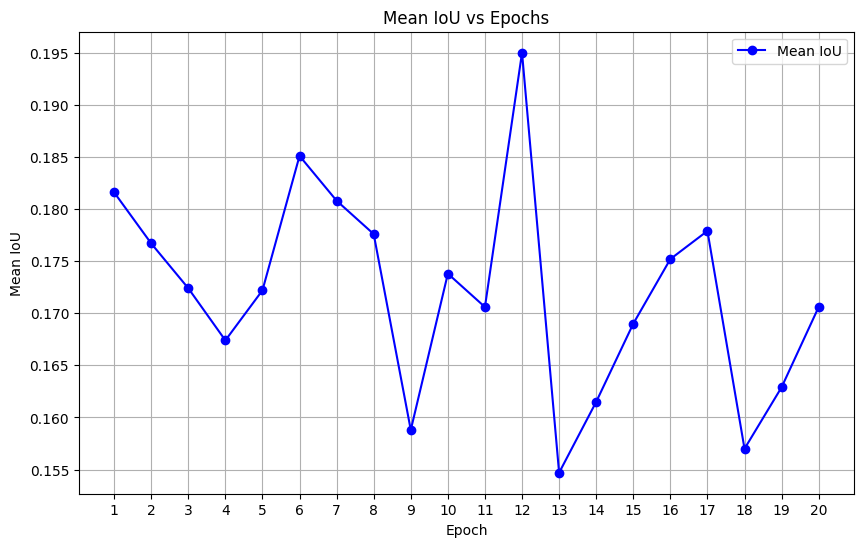

In [40]:
import matplotlib.pyplot as plt

# List of Mean IoU values for each epoch
mean_iou = [
    0.1816, 0.1767, 0.1724, 0.1674, 0.1722, 0.1851, 0.1808, 0.1776,
    0.1588, 0.1738, 0.1706, 0.1950, 0.1547, 0.1615, 0.1690, 0.1752,
    0.1779, 0.1570, 0.1629, 0.1706
]

# List of epochs
epochs = list(range(1, 21))

# Plotting the Mean IoU over epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, mean_iou, marker='o', color='b', label='Mean IoU')
plt.title('Mean IoU vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean IoU')
plt.grid(True)
plt.xticks(epochs)  # Ensure all epochs are shown
plt.legend()
plt.show()


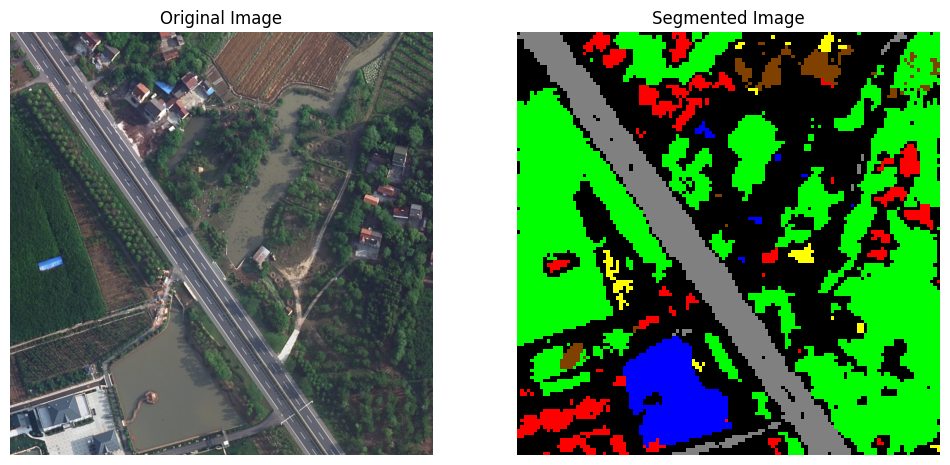

In [41]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Define label colors (R, G, B) for each class
class_labels = ["background", "building", "road", "water", "barren", "forest", "agriculture"]
label_colors = {
    "background": (0, 0, 0),        # Black
    "building": (255, 0, 0),       # Red
    "road": (128, 128, 128),       # Gray
    "water": (0, 0, 255),          # Blue
    "barren": (255, 255, 0),       # Yellow
    "forest": (0, 255, 0),         # Green
    "agriculture": (128, 64, 0),   # Brown
}

# Load a single image for segmentation
image_path = "/content/PIDNet/LoveDA/Test/Rural"
image_files = [f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f)) and not f.startswith('.')]
image_name = image_files[0]
image = Image.open(os.path.join(image_path, image_name)).convert('RGB')



# Preprocess the image (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_image = transform(image).unsqueeze(0).to(device)

# Perform inference with the model
model.eval()
with torch.no_grad():
    output = model(input_image)  # Shape: (1, num_classes, H, W)
    output = output[0]  # Remove auxiliary outputs if present
    preds = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # Shape: (H, W)

# Create a segmentation map
segmentation_map = np.zeros((preds.shape[0], preds.shape[1], 3), dtype=np.uint8)

for label_index, label_name in enumerate(class_labels):
    color = label_colors[label_name]
    segmentation_map[preds == label_index] = color

# Visualize the original image and segmentation map
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(segmentation_map)
plt.title("Segmented Image")
plt.axis("off")

plt.show()

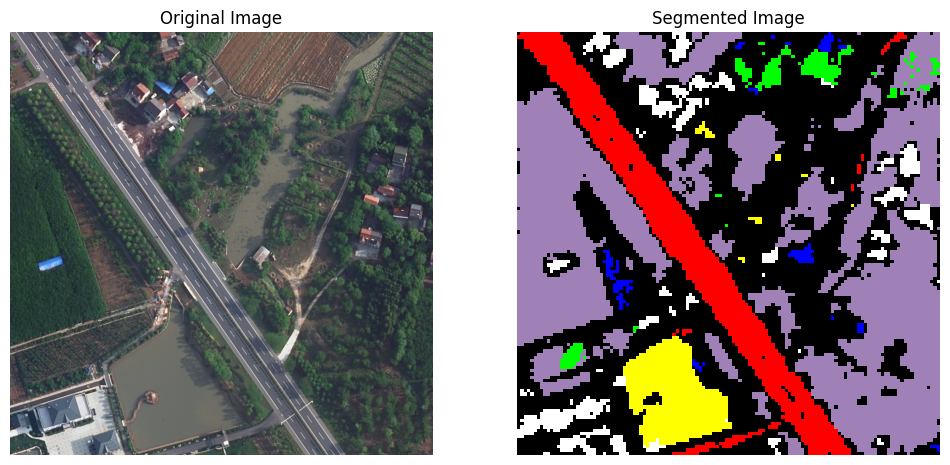

In [42]:
import torch
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import matplotlib.pyplot as plt

# Define the color map for each class (matching the official render.py)
COLOR_MAP = dict(
    IGNORE=(0, 0, 0),
    Background=(255, 255, 255),
    Building=(255, 0, 0),
    Road=(255, 255, 0),
    Water=(0, 0, 255),
    Barren=(159, 129, 183),
    Forest=(0, 255, 0),
    Agricultural=(255, 195, 128),
)

# Function to render the segmentation mask into a color image
def render(mask, color_map):
    cm = np.array(list(color_map.values())).astype(np.uint8)  # Convert color map to array
    color_mask = cm[mask]  # Map mask to corresponding color
    return Image.fromarray(np.uint8(color_mask))  # Convert to PIL image


# Load a single image for segmentation
image_path = "/content/PIDNet/LoveDA/Test/Rural"
image_name = os.listdir(image_path)[0]  # Choose the first image in the directory
image = Image.open(os.path.join(image_path, image_name)).convert('RGB')

# Preprocess the image (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_image = transform(image).unsqueeze(0).to(device)

# Perform inference with the model
model.eval()
with torch.no_grad():
    output = model(input_image)  # Shape: (1, num_classes, H, W)
    output = output[0]  # Remove auxiliary outputs if present
    preds = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # Shape: (H, W)

# Render the segmentation mask into a color image
segmentation_image = render(preds, COLOR_MAP)

# Visualize the original image and segmentation map
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(segmentation_image)
plt.title("Segmented Image")
plt.axis("off")

plt.show()